# **Implementation of Neural Networks with Backpropagation algorithm**







Import necessary packages

In [ ]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp

Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Load a CSV file

In [ ]:
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

Data Pre processing


*Convert string column to float*

In [ ]:
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

*Convert string column to integer*

In [ ]:
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

*Find the min and max values for each column*

In [ ]:
def dataset_minmax(dataset):
	minmax = list()
	stats = [[min(column), max(column)] for column in zip(*dataset)]
	return stats

*Rescale dataset columns to the range 0-1*

In [ ]:
def normalize_dataset(dataset, minmax):
	for row in dataset:
		for i in range(len(row)-1):
			row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

*Split a dataset into k folds*

In [ ]:
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

Calculate accuracy percentage

In [ ]:
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

Evaluate the algorithm using a cross validation split

In [ ]:
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

**Implementation of Backpropagation Algorithm**

Step 1: Initialize the neural network

In [ ]:
def initialize_network(n_inputs, n_hidden, n_outputs):
	network = list()
	hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
	network.append(hidden_layer)
	output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
	network.append(output_layer)
	return network

Step 2: Forward Propagate


Step 2a: Neuron Activation

In [ ]:
# Calculate neuron activation for an input
def activate(weights, inputs):
	activation = weights[-1]
	for i in range(len(weights)-1):
		activation += weights[i] * inputs[i]
	return activation

Step 2b: Transfer neuron activation

In [ ]:
#The transfer() implements the sigmoid equation
def transfer(activation):
	return 1.0 / (1.0 + exp(-activation))

Step 2c: Forward Propagation

In [ ]:
# Forward propagate input to a network output
def forward_propagate(network, row):
	inputs = row
	for layer in network:
		new_inputs = []
		for neuron in layer:
			activation = activate(neuron['weights'], inputs)
			neuron['output'] = transfer(activation)
			new_inputs.append(neuron['output'])
		inputs = new_inputs
	return inputs

Step 3: Back Propagate Error

Step 3a: Transfer Derivative

In [ ]:
# Calculate the derivative of an neuron output
def transfer_derivative(output):
	return output * (1.0 - output)

Step 3b: Error Propogation

In [ ]:
# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
	for i in reversed(range(len(network))):
		layer = network[i]
		errors = list()
		if i != len(network)-1:
			for j in range(len(layer)):
				error = 0.0
				for neuron in network[i + 1]:
					error += (neuron['weights'][j] * neuron['delta'])
				errors.append(error)
		else:
			for j in range(len(layer)):
				neuron = layer[j]
				errors.append(expected[j] - neuron['output'])
		for j in range(len(layer)):
			neuron = layer[j]
			neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

Step 4: Train Network

Step 4a: Update Weights

In [ ]:
# Update network weights with error
def update_weights(network, row, l_rate):
	for i in range(len(network)):
		inputs = row[:-1]
		if i != 0:
			inputs = [neuron['output'] for neuron in network[i - 1]]
		for neuron in network[i]:
			for j in range(len(inputs)):
				neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
			neuron['weights'][-1] += l_rate * neuron['delta']

Step 4b: Train Network

In [ ]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
	for epoch in range(n_epoch):
		for row in train:
			outputs = forward_propagate(network, row)
			expected = [0 for i in range(n_outputs)]
			expected[row[-1]] = 1
			backward_propagate_error(network, expected)
			update_weights(network, row, l_rate)

Step 5: Predict

In [ ]:
# Make a prediction with a network
def predict(network, row):
	outputs = forward_propagate(network, row)
	return outputs.index(max(outputs))

In [ ]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
	n_inputs = len(train[0]) - 1
	n_outputs = len(set([row[-1] for row in train]))
	network = initialize_network(n_inputs, n_hidden, n_outputs)
	train_network(network, train, l_rate, n_epoch, n_outputs)
	predictions = list()
	for row in test:
		prediction = predict(network, row)
		predictions.append(prediction)
	return(predictions)

Test the algorithm on Wheat Seeds dataset

In [ ]:
seed(1)
# load and prepare data
filename = '/content/gdrive/My Drive/ADA-Assignment 2/Neural Network - Backprop/seeds_dataset.csv' 
dataset = load_csv(filename)

for i in range(len(dataset[0])-1):
	str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)

# normalize input variables
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)

# evaluate algorithm
n_folds = 6 
l_rate = 0.3
n_epoch = 500
n_hidden = 5 
scores = evaluate_algorithm(dataset, back_propagation, n_folds, l_rate, n_epoch, n_hidden)

print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [94.28571428571428, 97.14285714285714, 97.14285714285714, 91.42857142857143, 97.14285714285714, 88.57142857142857]
Mean Accuracy: 94.286%


Plot the Scores

Text(0, 0.5, 'Scores')

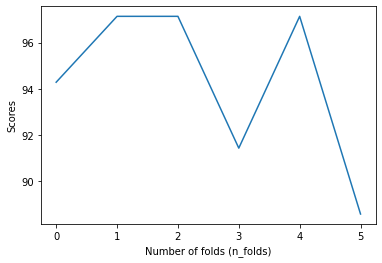

In [ ]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.xlabel("Number of folds (n_folds)")
plt.ylabel("Scores")
